2. This is an Image classification exercise. We will play with an expired Kaggle competition, please follow the rule of Kaggle and check the following page for more information https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview. After submit you results, use screenshot to show you score (see image below). They don’t provide ranking for this competition anymore. Thus, no need to show your ranking at Public/Private Leaderboard. (Name formation of your submission: MSBA.SessionX.Yourname, please replace X and Yourname with the correct string) using the screenshot on the Private Leaderboard, along with the description of your solutions and the codes (ipynb formation is highly encouraged) as the final submission.

In [ ]:
%load_ext cudf.pandas

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [ ]:
pip install kaggle --upgrade

In [ ]:
from google.colab import files
files.upload() # Use this to upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amubits","key":"8156d122b4ac3059d77cd70a16be601e"}'}

In [ ]:
# Make sure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API client
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Example: How to download a Kaggle dataset
#!kaggle datasets download -d 'dataset-name'

# Example: How to interact with Kaggle competitions
!kaggle competitions download -c 'dogs-vs-cats-redux-kernels-edition'

100% 813M/814M [00:34<00:00, 26.6MB/s]
100% 814M/814M [00:34<00:00, 24.8MB/s]


In [ ]:
import os

os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'
os.environ['LANGUAGE'] = 'en_US.UTF-8'

In [ ]:
!unzip 'dogs-vs-cats-redux-kernels-edition.zip'

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
import zipfile
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l1_l2
from keras import Input
from keras.applications import DenseNet121
from keras.applications import ResNet50V2
from keras.applications import ResNet152V2
from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import MobileNet
from keras.applications import MobileNetV2
from keras.applications import DenseNet121
from keras.applications import DenseNet169
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception


# EDA of the dataset

In [ ]:
train_path = '/content/train'
test_path = '/content/test'

In [ ]:
!ls -1 test/ | wc -l

12500


In [ ]:
!wc -l sample_submission.csv

12501 sample_submission.csv


In [ ]:
!head -5 sample_submission.csv

id,label
1,0.5
2,0.5
3,0.5
4,0.5


Total number of cat images: 12500
Total number of dog images: 12500
Average dimensions of cat images: (410.52264, 356.46712)
Average dimensions of dog images: (397.67544, 364.48904)


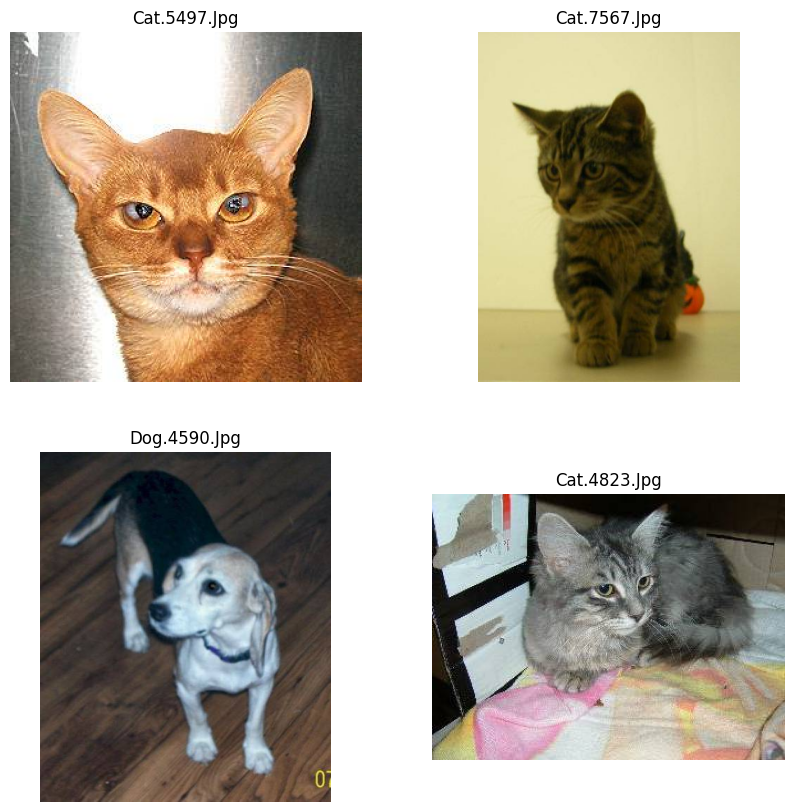

In [ ]:
# Counters for cats and dogs
cat_count = 0
dog_count = 0

# Lists to store image dimensions
cat_dims = []
dog_dims = []

# Loop through each file in the train directory
for filename in os.listdir(train_path):
    if filename.endswith('.jpg'):
        # Open the image
        image = Image.open(os.path.join(train_path, filename))

        # Check if the image is of a cat or a dog and update counters/dimensions
        if filename.startswith('cat'):
            cat_count += 1
            cat_dims.append(image.size)
        elif filename.startswith('dog'):
            dog_count += 1
            dog_dims.append(image.size)

# Calculate average dimensions
avg_cat_dim = tuple(map(lambda y: sum(y) / float(len(y)), zip(*cat_dims)))
avg_dog_dim = tuple(map(lambda y: sum(y) / float(len(y)), zip(*dog_dims)))

# Print the analysis
print(f"Total number of cat images: {cat_count}")
print(f"Total number of dog images: {dog_count}")
print(f"Average dimensions of cat images: {avg_cat_dim}")
print(f"Average dimensions of dog images: {avg_dog_dim}")

# Plotting some images
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    filename = os.listdir(train_path)[i]
    img = Image.open(os.path.join(train_path, filename))
    plt.imshow(img)
    plt.title(filename.split('_')[0].title())
    plt.axis('off')

plt.show()

In [ ]:
# Create a DataFrame for filenames and their corresponding labels
filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    category = 'dog' if filename.startswith('dog') else 'cat'
    categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Initialize the ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Splitting data into training and validation sets
)

# Generate augmented data for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Set as validation data
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1029: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if not all(df[x_col].apply(lambda x: isinstance(x, str))):
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1035: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if not all(df[y_col].apply(lambda x: isinstance(x, str))):


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1029: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if not all(df[x_col].apply(lambda x: isinstance(x, str))):
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1035: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if not all(df[y_col].apply(lambda x: isinstance(x, str))):


In [ ]:
# Count the number of cats and dogs in the training set
train_cats = train_generator.classes.count(0)
train_dogs = train_generator.classes.count(1)

# Print the counts
print(f"Training set - Cats: {train_cats}, Dogs: {train_dogs}")

Training set - Cats: 9973, Dogs: 10027


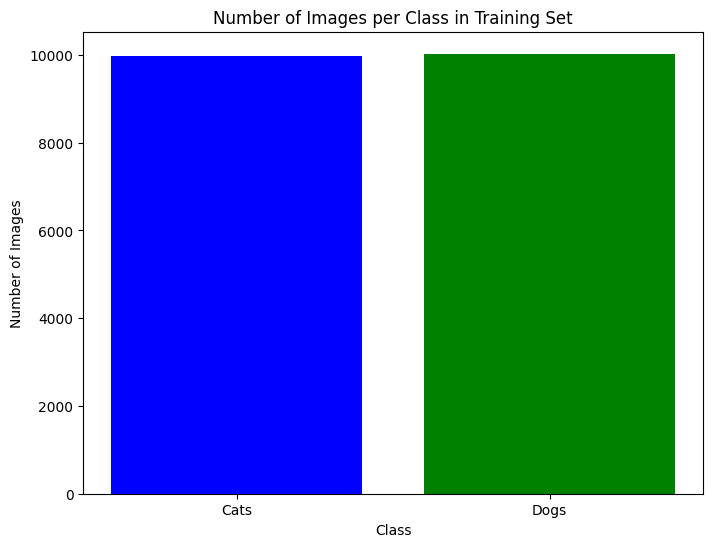

In [ ]:
# Class names
classes = ['Cats', 'Dogs']

# Counts
counts = [train_cats, train_dogs]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color=['blue', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.xticks(classes)
plt.show()

In [ ]:
# Count the number of cats and dogs in the training set
validation_cats = validation_generator.classes.count(0)
validation_dogs = validation_generator.classes.count(1)

# Print the counts
print(f"Validation set - Cats: {validation_cats}, Dogs: {validation_dogs}")

Validation set - Cats: 2527, Dogs: 2473


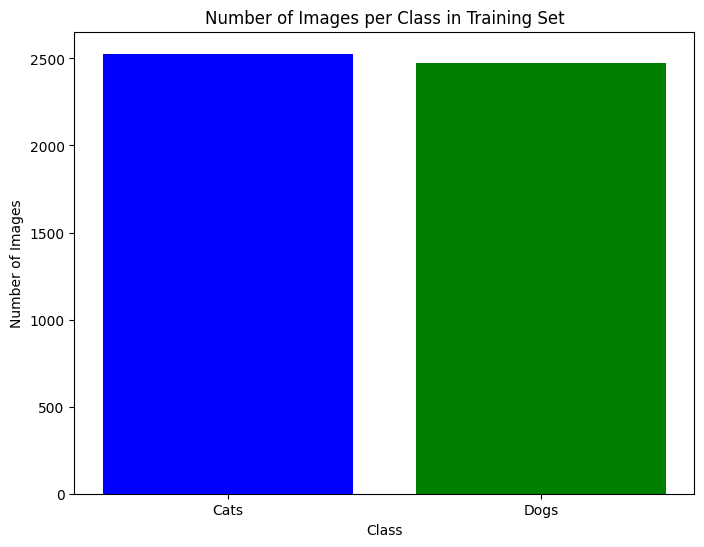

In [ ]:
# Class names
classes = ['Cats', 'Dogs']

# Counts
counts = [validation_cats, validation_dogs]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color=['blue', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.xticks(classes)
plt.show()

# Now the model building for predictions